# Matrix Factorisation with Keras

The following is an analysis for performing Matrix Factorisation (MF) with the Keras API using the Embedding layer.

For this experiment, we will use a reduced form of the Movie-Lens 20 Million data set. The data set has been processed to extract the top 10000 users and top 2000 movies in terms of ratings counts. 

Additionally, the user id and movie ids have been preprocessed such that they exist in sequential numerical order. To be more specific, all user ids exist between 0 to 9999, and all movie ids exist between 0 to 1999. The dataset consist of the following columns:
- `userId`: User ID ranging from 0 to 9999.
- `movieId`: Movie ID ranging from 0 to 1999.
- `rating`: Rating that user gave to movie. Range from 0.5 to 5.0.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.layers import Embedding, Input, Dot, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# Load in data
df = pd.read_csv("../data/small_rating.csv")

N = df.userId.max() + 1 # no of users
M = df.movieId.max() + 1 # no of movies

In [4]:
df.head()

,userId,movieId,rating
0,7307,10,4.5
1,7307,68,2.5
2,7307,143,3.5
3,7307,19,5.0
4,7307,85,4.5


In [5]:
# Number of users
N

10000

In [6]:
# Number of items
M

2000

# Train Test Split

As with any recommenders system, we will not expect to have a full complete ratings data set (since not all users will rate all movies, and not all movies will receive ratings from all users). Instead, we only have a partially filled matrix which is sparse in nature.

Thus, all the available data provided is only in terms of provided ratings, from which we can perform train-test split to obtain a set of training data and testing data. By training on the available ratings, we aim to learn the lower dimensional representations of users and items such that the reconstructed ratings are close to the actual ratings. 
- Note that each row of training data comes from a pair of User and Item input, with a label of the Rating. 
- For this analysis, the test dataset will be used for the validation set in the Keras model as shown later.
- Note that we can utilise the reduced dimensionality representations of users and items to obtain the ratings that were not given in the sparse ratings matrix (although there will not be any ground truths to compare them with).

<div align="center">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSULWEj9qZm6anO_qTV0MSVMNml28H0r0h6VA&usqp=CAU", width = 500>
</div>

In [7]:
# Reproducible train test split
np.random.seed(1)

# Split into train and test
df_shuffled = shuffle(df)
cutoff = int(0.9 * len(df_shuffled))
df_train = df_shuffled.iloc[:cutoff]
df_test = df_shuffled.iloc[cutoff:]

In [8]:
df_train

,userId,movieId,rating
1996526,7460,1153,2.5
1864726,2986,1028,4.5
4206286,2649,173,3.5
4672159,3549,594,1.5
3808932,2688,462,3.0
...,...,...,...
5298654,2383,36,4.0
3559315,6692,90,4.0
2747744,7542,555,2.0
3411346,3419,571,3.0


In [9]:
df_test

,userId,movieId,rating
904377,6119,663,1.0
2489067,4533,742,3.0
4388123,5393,461,3.0
3004970,680,503,4.0
1931382,9937,675,3.0
...,...,...,...
5030793,6374,1366,3.0
491263,6557,335,3.0
3937352,2434,1527,2.5
4686059,2747,17,4.0


# Keras Embedding layers
Using Keras, we are able to represent Matrix Factorisation (MF) with its Embedding layers. The Embedding layer is commonly used to convert discrete data that might be represented by sparse one-hot encoding into a dense representation with a specified input for hidden dimensionality. 

For intuition, the Embedding layers are often used in Natural Language Processing (NLP) with text formatting, where words or sequences of words (n-grams) can be used 

The key inputs for the Embedding layer consists of: 
- `input_dim`: The number of feature dimensions. In NLP, this refers to the expected vocabulary size for the corpus. In recommenders MF, this represents the number of users or items.
- `output_dim`: The hidden/latent dimensionality for dense representation.
- `input_length`: This refers to the sequence length that is often used in NLP for n-grams. For recommenders MF, this remains as 1 since the data used does not have sequences.

Ignoring the effect of `input_length` since it is 1, what the Embedding layer does is that it constructs a reduced representation of the work as represented by `input_dim` by `output_dim` which is similar to the U or M matrices in MF. Thus, for a given user or item, it is represented by a vector of shape (1 by `hidden_dimension`) in dense representation.

<div align="center">
    <img src="https://lazyprogrammer.me/wp-content/uploads/2016/04/matrix_factorization.png", width = 500>
</div>


In this workflow, the output dimensions of the Embedding layer is a 3D tensor of dimensions (batch_size, input_length, output_dim), where:
- `batch_size`: Number of training examples used per batch. Specified in the `model.compile()` step.
- `input_length`: 1 since we are not dealing with data with sequences (such as n-grams in NLP).
- `output_dim`: Hidden/latent dimensions for dense representation

The Embedding layer also allows for a regularisation input, which can be specified using other Keras regularizers class objects such as `l2`.

We will use Keras Embedding layer to represent the following:
- U: User matrix of dimensions N x K
- V: Item matrix of dimensions K x M
- User bias: Matrix of dimensions N x 1. This represents 1 bias per user.
- Item bias: Matrix of dimensions M x 1. This represents 1 bias per item.

For a reference on the Keras Embedding layer, please refer to its [documentation](https://keras.io/api/layers/core_layers/embedding/).

# Keras Model MF Supervised Learning Model
For each training data pairing of user and item, we have a training label which represents the rating that the user gave the product. Using Keras, we can set up the `U` and `V` embedding layers (of reduced dimensions) which take in corresponding data inputs in the form of `u` (for user) and `m` (for item). 

By giving `u` as an input to `U` embedding layer, this extracts out the relevant reduced dimension representation of the particular user in the training data pairing. Likewise, the same goes for the `m` input to the `V` embedding layer.

Thereafter, we perform a __dot product__ using the user representation $U_i$ and the item representation $V_i$. In the context of matrix factorisation, this is the exact equivalent of reconstructing the particular rating in the ratings matrix for a given user and item pair.

An additional note is that in this case, we will also be accounting for the user and item bias to each rating. We can also represent the bias using Embedding layers as well, but with an `output_dim` of 1. Both the user bias Embedding and item bias Embedding layers will take in corresponding inputs `u` and `m` to obtain the bias associated with each user and item.

At the same time, we will also center the data by subtracting the global mean rating of the training data to make the computation more efficient.

$$\hat{rating_{ij}} = U_i \cdot V_j + user\_bias_i + item\_bias_j + rating_{\mu},\ where$$
$$U_i = User\ i\ representation$$
$$V_j = Item\ j\ representation$$
$$user\_bias_i = Bias\ for\ user\ i$$
$$item\_bias_i = Bias\ for\ item\ j$$
$$rating_{\mu} = Global\ mean\ rating\ (training\ data)$$


In the following, we obtain the parameters for the experiment such as the hidden/latent dimensionality, the global rating mean for the training data, as well as Keras model parameters.

In [10]:
# Initialize variables
K = 20 # latent dimensionality

# Calculate the mean ratings to be used 
mu = df_train.rating.mean()

# Model parameters
epochs = 10
reg = 0.001 # regularization penalty if required

In the following, we set up the Keras layers as described using the concept of Embedding layers for representation, and obtaining the predicted rating for each pair of user and movie. This is set up such that the model takes in a tuple of 2 inputs `u` and `m`, which are the corresponding user ID and the movie ID.

Since we are dealing with ratings (which is a continuous response variable), we can use Mean Squared Error as the loss function.

As a slight modification to the mathematical equation, we will make the label data (Y) such that it is the actual ratings minus the global ratings means of the training data. This is demonstrated in the following:
$$\hat{rating_{ij}} - rating_{\mu} = U_i \cdot V_j + user\_bias_i + item\_bias_j$$
$$Y = U_i \cdot V_j + user\_bias_i + item\_bias_j$$

In [11]:
# Keras model
# Specifying shape of u and m has downstream implications for the "input_length" for u_embedding and m_embedding.
# Since we are not dealing with text data, the "input_length" is 1.
u = Input(shape = (1,)) 
m = Input(shape = (1,))

# Output Embedding layer of Keras (1, Sequence_length, K (latent/hidden dimensionality for dense representation))
# In the context of matrix factorisation, K is the same for both U and M embedding layers
# sequence_length = 1 since we are dealing with discrete users and items, and not NLP text
u_embedding = Embedding(input_dim = N, output_dim = K, embeddings_regularizer= l2(reg))(u) # Output Embedding layer (Batch_size, 1, K)
m_embedding = Embedding(input_dim = M, output_dim = K, embeddings_regularizer = l2(reg))(m) # Output Embedding layer (Batch_size, 1, K)

# Adding Bias for each Embedding layer. 
u_bias = Embedding(input_dim = N, output_dim = 1, embeddings_regularizer=l2(reg))(u) # (Batch_size, 1, 1)
m_bias = Embedding(input_dim = M, output_dim = 1, embeddings_regularizer=l2(reg))(m) # (Batch_size, 1, 1)

# ratings (dot product between user embedding and item embedding)
# "axes" input is to specify the axis for performing the dot product operation
ratings = Dot(axes=2)([u_embedding, m_embedding]) # (Batch_size, 1, 1)

# Account for biases in eventual rating
ratings = Add()([ratings, u_bias, m_bias])

# Flattening/Reducing from 3D tensor to 2D tensor
ratings = Flatten()(ratings) # (Batch_size, 1)

model = Model(inputs=[u, m], outputs = ratings)
model.compile(
    # Mse loss function includes regularisation
    loss = "mse", 
    # Optimizer with hyper-parameters
    optimizer = SGD(lr = 0.01, momentum = 0.9),
    # Explicit stating of mse in metrics is returns loss function without regularisation portion
    metrics = ["mse"] 
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 20)        200000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 20)        40000       input_2[0][0]                    
______________________________________________________________________________________________

With the model summary, we can observe how the inputs `u` and `m` are used to connect with the various embedding layers (`u` for `U` & `u_bias`, `m` for `M` & `m_bias`). Thereafter, we obtain the predicted ratings by performing the necessary dot product with arithmetic operations (accounting for the bias).

As shown in the following, the inputs are based on the pairings of the user ID and movie ID for each rating. The test dataset which we previously obtained is used for the validation data set.

In [13]:
# Train the model
matrix_factorisation = model.fit(
    # Training data in tuples (u, m)
    x = [df_train.userId.values, df_train.movieId.values],
    
    # Labels are the deviations from the average ratings
    y = df_train.rating.values - mu,
    epochs= epochs,
    batch_size = 128,
    validation_data = (
        [df_test.userId.values, df_test.movieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/10


/home/kenneth/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


37913/37913 [==============================] - 113s 3ms/step - loss: 0.9582 - mse: 0.8915 - val_loss: 0.9409 - val_mse: 0.8801
Epoch 2/10
37913/37913 [==============================] - 115s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9410 - val_mse: 0.8804
Epoch 3/10
37913/37913 [==============================] - 107s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9409 - val_mse: 0.8802
Epoch 4/10
37913/37913 [==============================] - 105s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9409 - val_mse: 0.8798
Epoch 5/10
37913/37913 [==============================] - 109s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9409 - val_mse: 0.8802
Epoch 6/10
37913/37913 [==============================] - 113s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9408 - val_mse: 0.8801
Epoch 7/10
37913/37913 [==============================] - 116s 3ms/step - loss: 0.9404 - mse: 0.8796 - val_loss: 0.9410 - val_mse: 0.8799
Epoch 8/10
37913/37913 [=====================

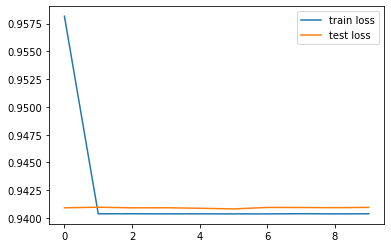

In [14]:
# Plot losses (loss is MSE with regularisation term)
plt.plot(matrix_factorisation.history['loss'], label="train loss")
plt.plot(matrix_factorisation.history['val_loss'], label="test loss")
plt.legend()
plt.show()

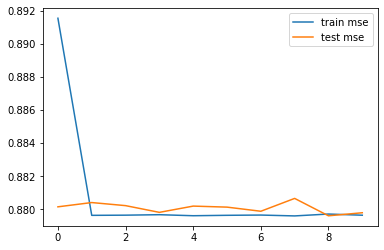

In [15]:
# Plot metric ("mse" metric is MSE without regularisation term)
plt.plot(matrix_factorisation.history['mse'], label="train mse")
plt.plot(matrix_factorisation.history['val_mse'], label="test mse")
plt.legend()
plt.show()

As shown by the final MSE metric, the loss for the training and test data have very similar loss quantum hovering around 0.880. This shows that the model with a latent dimensionality of K = 20 has managed to generalise well.